# 課題
## Car Fuel Consumption
https://www.kaggle.com/anderas/car-consume

## 目的（ゴール）

### DAY1
- 目的変数と説明変数の関係を確認するためのグラフを作成
- 目的変数を説明するのに有効そうな説明変数を見つける
- DAY1で学んだアルゴリズムを利用する
    - 回帰問題ー＞線形回帰
    - 質的変数が扱えないアルゴリズムを使う場合、ダミー変数に置き換え
- 予測精度または識別精度を確認する
    - 回帰問題ー＞MSE、RMSE、MAE


### DAY2、DAY3
- 前処理の改善
    - 前処理の改善と、欠測値と異常値を適切に処理する
        - DAY2
            - 正規化 / 標準化
            - 無相関化 / 白色化
        - DAY3
            - 特徴選択
        
- モデル
    - DAY2、3で学んだアルゴリズムを利用してモデルをつくり、DAY1宿題提出時の精度と比較する
        - DAY2
            - 線形回帰の正則化(L1、L2、ElasticNet)
            - サポートベクターマシン(線形、非線形）
                - 回帰->SVR使う
        - DAY3
            - 木モデル(決定木・ランダムフォレスト) 
            - ニューラルネットワーク

- 評価
    - 交差検証、ホールドアウト法などで汎化性能を確認する
    - 交差検証によるパラメータチューニングを行う
        - グリッドサーチを使って最適なパラメタを見つける
    - パラメータチューニング後のモデルによって、精度および結果の評価を行う
        - グリッドサーチで見つけたモデル・パラメタを使用し精度を測る

- まとめ
    - 前回から取り組んだ内容・工夫、精度がどのように変化したかをまとめる

## データセット

### 使用するデータセット
measurements.csv <br>

### 各項目の説明
| columns| 説明| 内容| 種類|
|:-----------|------------:|:------------:|:------------:|
| distance| 距離| km| 量的変数|
| consume| 消費量| L / 100km| 量的変数|
| speed| 平均速度| km/h| 量的変数|
| temp_inside| 内気温| ℃| 量的変数|
| temp_outside| 外気温|　℃| 量的変数|
| specials| スペシャル| 雨雪などの天気 <br>エアコンON/OFF| 質的変数|
| gas_type| ガソリンタイプ|　SP98、E10| 質的変数|
| AC| エアコン| 'ON':1、'OFF':0| 質的変数|
| rain| 雨| '雨':1、'雨じゃない':0| 質的変数|
| sun| 晴れ| '晴れ':1、'晴れじゃない':0| 質的変数|
| refill liters| リッター補充時の金額| ユーロ？| 量的変数|
| refill gas| ガソリン補充の種類| SP98、E10| 質的変数|

## ソースコード

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
# データ読み取り
df_data = pd.read_csv('./data/measurements.csv')

In [3]:
# 取得したデータ確認
display(df_data.head())
display(df_data.describe())

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN


,speed,temp_outside,AC,rain,sun
count,388.000000,388.000000,388.000000,388.000000,388.000000
mean,41.927835,11.358247,0.077320,0.123711,0.082474
std,13.598524,6.991542,0.267443,0.329677,0.275441
min,14.000000,-5.000000,0.000000,0.000000,0.000000
25%,32.750000,7.000000,0.000000,0.000000,0.000000
50%,40.500000,10.000000,0.000000,0.000000,0.000000
75%,50.000000,16.000000,0.000000,0.000000,0.000000
max,90.000000,31.000000,1.000000,1.000000,1.000000


### データの整形

In [4]:
# 小数点表示を','から'.'に変更
df_data = df_data.replace('\,', '.', regex = True)

# 文字列から数値に変換
df_data['distance'] = df_data['distance'].astype(float)
df_data['consume'] = df_data['consume'].astype(float)
df_data['speed'] = df_data['speed'].astype(float)
df_data['temp_inside'] = df_data['temp_inside'].astype(float)
df_data['temp_outside'] = df_data['temp_outside'].astype(float)
df_data['refill liters'] = df_data['refill liters'].astype(float)

# 'SP98':0, 'E10':1に変換
df_data.loc[df_data['gas_type'] == 'SP98', 'gas_type'] = 0
df_data.loc[df_data['gas_type'] == 'E10', 'gas_type'] = 1
df_data.loc[df_data['refill gas'] == 'SP98', 'refill gas'] = 0
df_data.loc[df_data['refill gas'] == 'E10', 'refill gas'] = 1

In [5]:
# スペシャルの中身確認
df_data['specials'].value_counts()

rain                  32
sun                   27
AC rain                9
ac                     8
AC                     6
snow                   3
sun ac                 3
AC snow                1
half rain half sun     1
ac rain                1
AC Sun                 1
AC sun                 1
Name: specials, dtype: int64

In [6]:
# '大文字小文字がバラバラなのでAC'と'sun'に統一
df_data.loc[df_data['specials'] == 'Sun', 'specials'] = 'sun'
df_data.loc[df_data['specials'] == 'ac', 'specials'] = 'AC'
df_data.loc[df_data['specials'] == 'AC Sun', 'specials'] = 'AC sun'
df_data.loc[df_data['specials'] == 'sun ac', 'specials'] = 'AC sun'
df_data.loc[df_data['specials'] == 'ac rain', 'specials'] = 'AC rain'
df_data['specials'].value_counts()

rain                  32
sun                   27
AC                    14
AC rain               10
AC sun                 5
snow                   3
AC snow                1
half rain half sun     1
Name: specials, dtype: int64

In [7]:
# 'specials’をダミー変数に置き換え
df_specials = pd.get_dummies(df_data['specials'])
df_specials.columns = [
    '[s]AC', '[s]AC rain', '[s]AC snow', '[s]AC sun', '[s]half rain half sun', '[s]rain', '[s]snow', '[s]sun'
]
df_data = pd.concat([df_data, df_specials], axis=1)

# ダミー変数に置き換えたので'specials'は削除
df_data = df_data.drop(['specials'], axis=1)

In [8]:
# AC,rain,sunとspecialのAC,rain,sunはまとめることが出来そう
print("'AC'と'[s]AC'の比較")
print((df_data['AC'] == df_data['[s]AC']).value_counts())

print("\n'rain'と'[s]rainの比較")
print((df_data['rain'] == df_data['[s]rain']).value_counts())

print("\n'sun'と'[s]sunの比較")
print((df_data['sun'] == df_data['[s]sun']).value_counts())

'AC'と'[s]AC'の比較
True     370
False     18
dtype: int64

'rain'と'[s]rainの比較
True     372
False     16
dtype: int64

'sun'と'[s]sunの比較
True     383
False      5
dtype: int64


In [9]:
# Falseがあるが、チェックし忘れている可能性もあるので、「or」を取り、'[s]XXX'を削除
df_data['AC'] = (df_data['AC'] | df_data['[s]AC'])
df_data['rain'] = (df_data['rain'] | df_data['[s]rain'])
df_data['sun'] = (df_data['sun'] | df_data['[s]sun'])

df_data = df_data.drop(['[s]AC'], axis=1)
df_data = df_data.drop(['[s]rain'], axis=1)
df_data = df_data.drop(['[s]sun'], axis=1)

,distance,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,refill liters,[s]AC rain,[s]AC snow,[s]AC sun,[s]half rain half sun,[s]snow
distance,NaN,0.562299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
speed,0.562299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
temp_inside,NaN,NaN,NaN,0.361308,NaN,0.313197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
temp_outside,NaN,NaN,0.361308,NaN,NaN,NaN,NaN,0.346903,NaN,NaN,NaN,NaN,NaN,NaN
gas_type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AC,NaN,NaN,0.313197,NaN,NaN,NaN,NaN,NaN,NaN,0.551960,NaN,0.387738,NaN,NaN
rain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.432885,NaN,NaN,NaN,NaN
sun,NaN,NaN,NaN,0.346903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.381097,NaN,NaN
refill liters,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
[s]AC rain,NaN,NaN,NaN,NaN,NaN,0.551960,0.432885,NaN,NaN,NaN,NaN,NaN,NaN,NaN


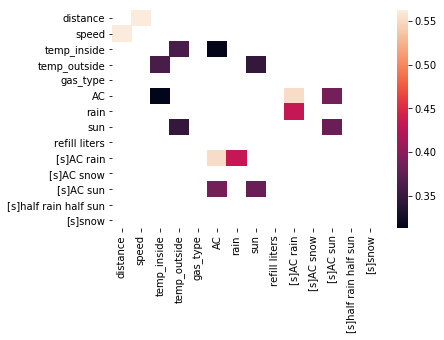

In [10]:
# 説明変数同士の相関を確認
exp_corr = df_data.drop(['consume'], axis=1).corr()[(df_data.corr() >= 0.3) & (df_data.corr() != 1)]
display(exp_corr)
sns.heatmap(exp_corr)

In [11]:
def decorrelation_data(data1):
    """無相関化"""
    
    # 分散・共分散を求める
    cov = np.cov(data1, rowvar=0)
    
    # 分散共分散行列の固有ベクトルを用いて
    _, S = np.linalg.eig(cov)
    
    #データを無相関化
    data1_decorr = np.dot(S.T, data1.T).T

    data1 = data1_decorr

In [12]:
# TODO もっと良いやり方あると思う
# 相関が強い説明変数を無相関化
removed_na_exp_corr = []

# Noneを取り除く
for column in exp_corr.columns:
    for i in exp_corr.index:
        if exp_corr.notna().loc[i, column]:
            removed_na_exp_corr.append([i, column, exp_corr.loc[i, column]])

# 同じデータを取り除く
tmp = []
for i in range(len(removed_na_exp_corr) - 1):
    for j in np.arange(i, len(removed_na_exp_corr)):
        if (removed_na_exp_corr[i][0] == removed_na_exp_corr[j][1]) and (removed_na_exp_corr[i][1] == removed_na_exp_corr[j][0]):
            tmp.append(removed_na_exp_corr[i])
removed_na_exp_corr = tmp
print(removed_na_exp_corr)

# 上手くいかない！！！！！！
# # 無相関化
# tmp = []
# for i in range(len(removed_na_exp_corr)):
    
# #     print(df_data[removed_na_exp_corr[i][0]].values)
# #     print(df_data[removed_na_exp_corr[i][1]].values)

#     tmp = np.concatenate([df_data[removed_na_exp_corr[i][0]].values, df_data[removed_na_exp_corr[i][1]].values], axis=0)
#     print(tmp)
#     decorrelation_data(df_data[removed_na_exp_corr[i][0]])

[['speed', 'distance', 0.5622988220307988], ['temp_outside', 'temp_inside', 0.3613077166616399], ['AC', 'temp_inside', 0.31319674805474546], ['sun', 'temp_outside', 0.34690341032629884], ['[s]AC rain', 'AC', 0.5519596889337881], ['[s]AC sun', 'AC', 0.38773845576844457], ['[s]AC rain', 'rain', 0.43288540137443243], ['[s]AC sun', 'sun', 0.38109708335956916]]


In [13]:
# 欠損値確認
df_data.isnull().sum()

distance                   0
consume                    0
speed                      0
temp_inside               12
temp_outside               0
gas_type                   0
AC                         0
rain                       0
sun                        0
refill liters            375
refill gas               375
[s]AC rain                 0
[s]AC snow                 0
[s]AC sun                  0
[s]half rain half sun      0
[s]snow                    0
dtype: int64

In [14]:
#  temp_insideの欠損値は、平均値を入れる
# TODO 平均値で良いのか？
df_data['temp_inside'] = df_data['temp_inside'].fillna(
    df_data['temp_inside'].mean()
)

# 'refill liters','refil gas'は欠損値多すぎるので削除
# TODO 消さずに使う方法は無いか？
df_data = df_data.drop('refill liters', axis=1)
df_data = df_data.drop('refill gas', axis=1)

### グラフを可視化

In [15]:
# 散布図行列は表示項目が多すぎて見づらいため省略
# pd.plotting.scatter_matrix(df_data, figsize=(10,10))
# plt.show()

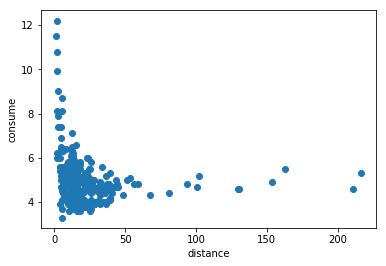

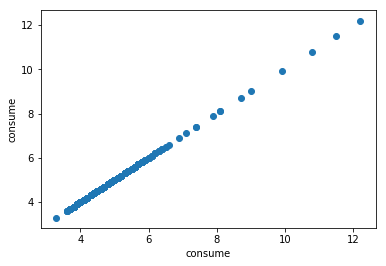

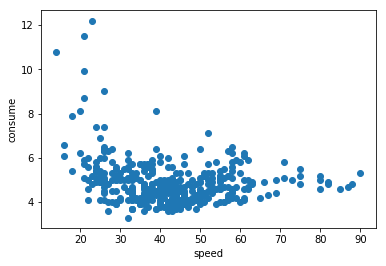

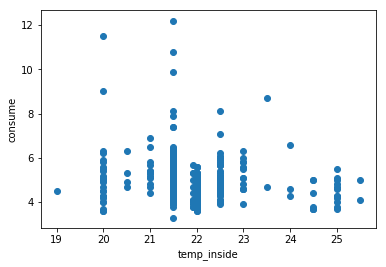

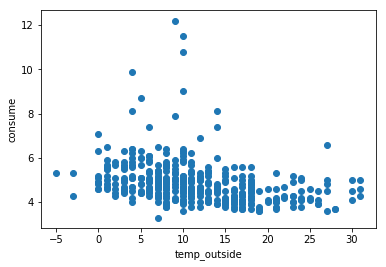

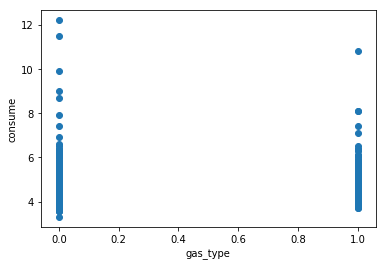

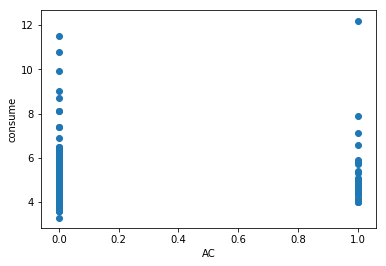

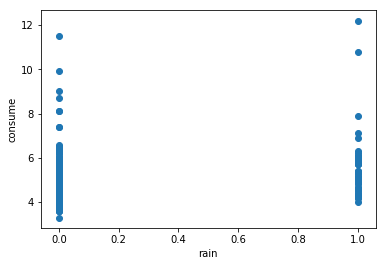

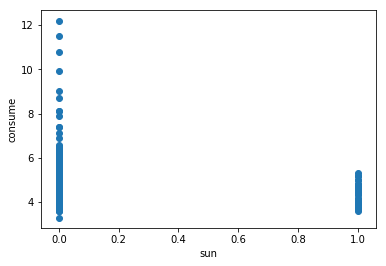

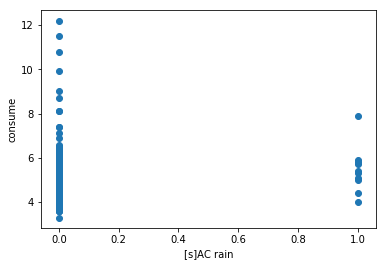

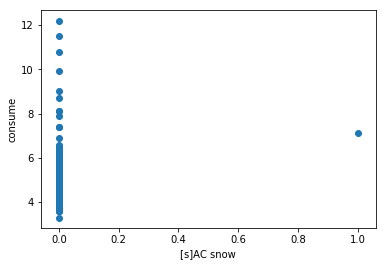

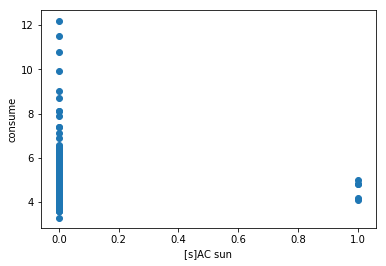

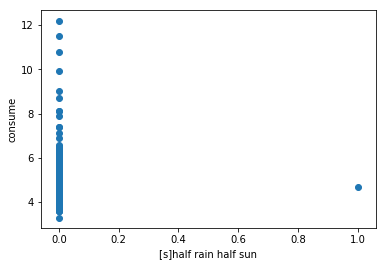

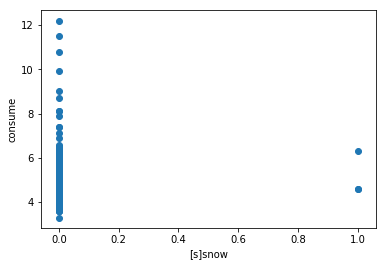

In [16]:
# consumeに絞って散布図表示してみる
for column in df_data.columns:
    plt.scatter(df_data[column], df_data['consume'])
    plt.xlabel(column)
    plt.ylabel('consume')
    plt.show()

[s]half rain half sun    0.010462
gas_type                 0.015327
[s]snow                  0.021755
[s]AC sun                0.036804
[s]AC rain               0.084747
AC                       0.092276
[s]AC snow               0.107772
distance                 0.128967
temp_inside              0.160623
sun                      0.170667
speed                    0.227866
rain                     0.248118
temp_outside             0.320811
consume                  1.000000
Name: consume, dtype: float64

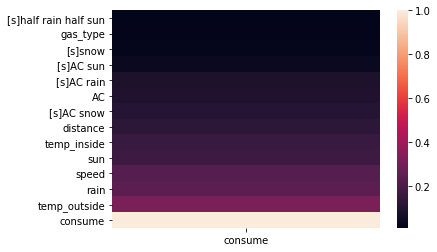

In [17]:
# 'consume'に絞って、相関係数、ヒートマップを可視化
consume_corr = df_data.corr()['consume']

# 相関係数の絶対値でソート
sorted_consume_corr = abs(consume_corr).sort_values(ascending=True)

display(sorted_consume_corr)
sns.heatmap(pd.DataFrame(sorted_consume_corr))

### 検証

#### 説明変数の選択
consumeとの相関係数（の絶対値）が大きいデータを選択すれば一般的には問題なさそうだが、念の為、最初は説明変数全てを選択し、徐々に説明変数の数を減らしながら精度を計測してみた。

In [18]:
# TODO 正規化/標準化、無相関化/白色化
def pre_process_for_train_data(X_train, X_test):
    """訓練データに対する前処理"""
    
    # 無相関化
#     decorrelation_data(X_train)
    
    # 標準化
    stdsc = StandardScaler()
    X_train_std = stdsc.fit_transform(X_train)
    X_test_std = stdsc.transform(X_test)
    
    return X_train_std, X_test_std

In [19]:
def evaluate_normal_precision(X, y, model):
    """訓練誤差のみ"""
    
    # モデルを学習
    model.fit(X, y)

    # 　制度の確認
    y_pred = model.predict(X)

    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mse)
    
#     print("MSE = {}".format(round(mse, 3)))
#     print("MAE = {}".format(round(mae, 3)))
#     print("RMSE = {}".format(round(rmse, 3)))
    
    return mse, mae, rmse

In [20]:
def evaluate_hold_out(X, y, model):
    """ホールドアウト法"""
    
    # 全データのうち、何%をテストデータにするか（今回は20%に設定）
    test_size = 0.2
    
    # ホールドアウト法を実行（テストデータはランダム選択）
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)
    
    # 訓練データに対する前処理
    X_train, X_test = pre_process_for_train_data(X_train, X_test)
    
    # 学習用データを使ってモデルを学習
    model.fit(X_train, y_train)

    # 学習用データに対する予測を実行
    y_pred_train = model.predict(X_train)
    
    predict_mae = mean_absolute_error(y_train, y_pred_train)

    # テストデータに対する予測を実行
    y_pred_test = model.predict(X_test)

    # テストデータに対するMAEを計算（汎化誤差の評価）
    test_mae = mean_absolute_error(y_test, y_pred_test)

#     print("predict MAE = {}".format(round(predict_mae, 3)))
#     print("test MAE = {}".format(round(test_mae, 3)))

    return predict_mae, test_mae

In [21]:
def evaluate_cross_varidation(X, y, model):
    """クロスバリデーション法"""
    
    # グループ数を設定（今回は5分割）
    n_split = 5

    # テスト役を交代させながら学習と評価を繰り返す
    cross_valid_mae = 0
    split_num = 1
    for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        
        # 訓練データに対する前処理
        X_train, X_test = pre_process_for_train_data(X_train, X_test)

        # 学習用データを使ってモデルを学習
        model.fit(X_train, y_train)

        # テストデータに対する予測を実行
        y_pred_test = model.predict(X_test)

        # テストデータに対するMAEを計算
        mae_fold = mean_absolute_error(y_test, y_pred_test)
#         print("Fold{} MAE = {}".format(split_num, round(mae_fold, 3)))

        # 後で平均を取るためにMAEを加算
        cross_valid_mae += mae_fold
        split_num += 1

    # MAEの平均値を最終的な汎化誤差値とする
    final_cv_mae = cross_valid_mae / n_split
    
#     print("Cross Validation MAE = {}".format(round(final_cv_mae, 3)))
    
    return final_cv_mae

In [22]:
def evaluate_grid_search(X, y, model, parameters):
    """グリッドサーチ法"""

    # TODO test_sizeは0.3固定でいいか？
    #  ここもクロスバリデーションを使うべきか？
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
    
    # 訓練データに対する前処理
    X_train, X_test = pre_process_for_train_data(X_train, X_test)

    est = GridSearchCV(model, parameters, cv=3)
    est.fit(X_train, y_train)

    final_gs_best_params = est.best_params_
    final_gs_best_score = est.best_score_

    #  クラス名を取得
    model_name = str(model).split('(')[0]

    # 最適パラメータを用いて識別する
    est2 = eval(model_name)(**est.best_params_)
    est2.fit(X_train, y_train)
    
    # テストデータに対する予測を実行
    y_pred_test = est2.predict(X_test)

    # テストデータに対するMAEを計算
    final_gs_mae = mean_absolute_error(y_test, y_pred_test)

#     print("best params = {}".format(final_gs_best_params))
#     print("best score = {}".format(final_gs_best_score))
#     print("Grid Search MAE = {}".format(round(final_gs_mae, 3)))
    
    return  final_gs_mae, final_gs_best_params, final_gs_best_score

### 評価したいモデルとパラメタを設定

In [23]:
# TODO パラメタ増やしたり多項式もやりたいが時間ない・・・

evaluate_models = {}

# 線形回帰 正則化なし
evaluate_models['LinearRegression'] = {
    'model':LinearRegression(),
    'parameters':{
    }
}

# 線形回帰　Ridge
evaluate_models['Ridge'] = {
    'model':Ridge(),
    'parameters':{
        'alpha':[0.0, 1e-8, 1e-5, 1e-1]
    }
}

# 線形回帰　Lasso
evaluate_models['Lasso'] = {
    'model':Lasso(),
    'parameters':{
        'alpha':[1e-20, 1e-3, 1e-2, 1e-1], 
#         'max_iter':[1e7]
    }
}

# 線形回帰 ElasticNet
evaluate_models['ElasticNet'] = {
    'model':ElasticNet(),
    'parameters':{
        'alpha':[1e-20, 1e-3, 1e-2, 1e-1], 
        'l1_ratio':[0, 0.1, 0.5, 1.0],
#         'max_iter':[1e7]
        'alpha':[1e-20],
        'l1_ratio':[0]
    }
}

# SVR
evaluate_models['SVR'] = {
    'model':SVR(),
    'parameters':{
        'kernel':['linear', 'rbf'], 
        'C':[1, 5, 10]
    }
}

#### モデルの評価

In [24]:
# TODO ワーニング消したい
final_mse, final_mae, final_rmse = {}, {}, {}
final_predict_mae, final_test_mae = {}, {}
final_cv_mae = {}
final_gs_best_params, final_gs_best_score, final_gs_mae = {}, {}, {}
final_exp_data = {}

# 最初は説明変数全てを選択し、徐々に数を減らしながら精度を計測
exp_data = sorted_consume_corr
for exp_num in range(len(exp_data)):
    if exp_num == 0:
        exp_data = exp_data.drop('consume')
    else:
        exp_data = exp_data.drop(exp_data.index[0])

    if not len(exp_data):
        # 該当する説明変数無し -> 終了！
        break

    X = df_data[exp_data.index].values
    y = df_data['consume'].values

    mse, mae, rmse = {}, {}, {}
    predict_mae, test_mae = {}, {}
    cv_mae = {}
    gs_best_params, gs_best_score, gs_mae = {}, {}, {}
    
    #  evaluate_modelsに設定したモデルを順番に評価
    # 　グリッドサーチ以外はパラメタはデフォルト値
    for key, model in evaluate_models.items():
        
        # 訓練誤差のみ
        mse[key], mae[key], rmse[key] = evaluate_normal_precision(X, y, model['model'])
        # ホールドアウト法
        predict_mae[key], test_mae[key] = evaluate_hold_out(X, y, model['model'])
        
        # クロスバリデーション法
        cv_mae[key] = evaluate_cross_varidation(X, y, model['model'])
        
        # グリッドサーチ法
        gs_mae[key], gs_best_params[key], gs_best_score[key] = evaluate_grid_search(X, y, model['model'], model['parameters'])

    #　結果を保持
    final_mse[exp_num], final_mae[exp_num], final_rmse[exp_num] = mse, mae, rmse
    final_predict_mae[exp_num], final_test_mae[exp_num] = predict_mae, test_mae
    final_cv_mae[exp_num] = cv_mae
    final_gs_mae[exp_num], final_gs_best_params[exp_num], final_gs_best_score[exp_num] = gs_mae, gs_best_params, gs_best_score
    final_exp_data[exp_num] = exp_data

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.985296e-49
  overwrite_a=True).T
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.856188e-33
  overwrite_a=True).T
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

#### 定性評価

In [25]:
# モデル毎の精度
lenearregression_cv_mae = {}
ridge_cv_mae = {}
lasso_cv_mae = {}
elasticnet_cv_mae = {}
svr_cv_mae = {}

lenearregression_gs_mae = {}
ridge_gs_mae = {}
lasso_gs_mae = {}
elasticnet_gs_mae = {}
svr_gs_mae = {}

for i in final_cv_mae:
    lenearregression_cv_mae[i] = [v for k, v in final_cv_mae[i].items() if k == 'LinearRegression']
    ridge_cv_mae[i] = [v for k, v in final_cv_mae[i].items() if k == 'Ridge']
    lasso_cv_mae[i] = [v for k, v in final_cv_mae[i].items() if k == 'Lasso']
    elasticnet_cv_mae[i] = [v for k, v in final_cv_mae[i].items() if k == 'ElasticNet']
    svr_cv_mae[i] = [v for k, v in final_cv_mae[i].items() if k == 'SVR']
    
    lenearregression_gs_mae[i] = [v for k, v in final_gs_mae[i].items() if k == 'LinearRegression']
    ridge_gs_mae[i] = [v for k, v in final_gs_mae[i].items() if k == 'Ridge']
    lasso_gs_mae[i] = [v for k, v in final_gs_mae[i].items() if k == 'Lasso']
    elasticnet_gs_mae[i] = [v for k, v in final_gs_mae[i].items() if k == 'ElasticNet']
    svr_gs_mae[i] = [v for k, v in final_gs_mae[i].items() if k == 'SVR']

In [26]:
# 説明変数毎の精度
min_cv_mae = {}
min_cv_model = {}
min_gs_mae = {}
min_gs_model = {}
best_gs_best_params = {}
bestl_gs_best_score = {}

for i in final_cv_mae:
    min_cv_mae[i] = min(final_cv_mae[i].values())
    min_cv_model[i] = [k for k, v in final_cv_mae[i].items() if v == min_cv_mae[i]]

    min_gs_mae[i] = min(final_gs_mae[i].values())
    min_gs_model[i] = [k for k, v in final_gs_mae[i].items() if v == min_gs_mae[i]]
    best_gs_best_params[i] = final_gs_best_params[i][min_gs_model[i][0]]
    bestl_gs_best_score[i] = final_gs_best_score[i][min_gs_model[i][0]]

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


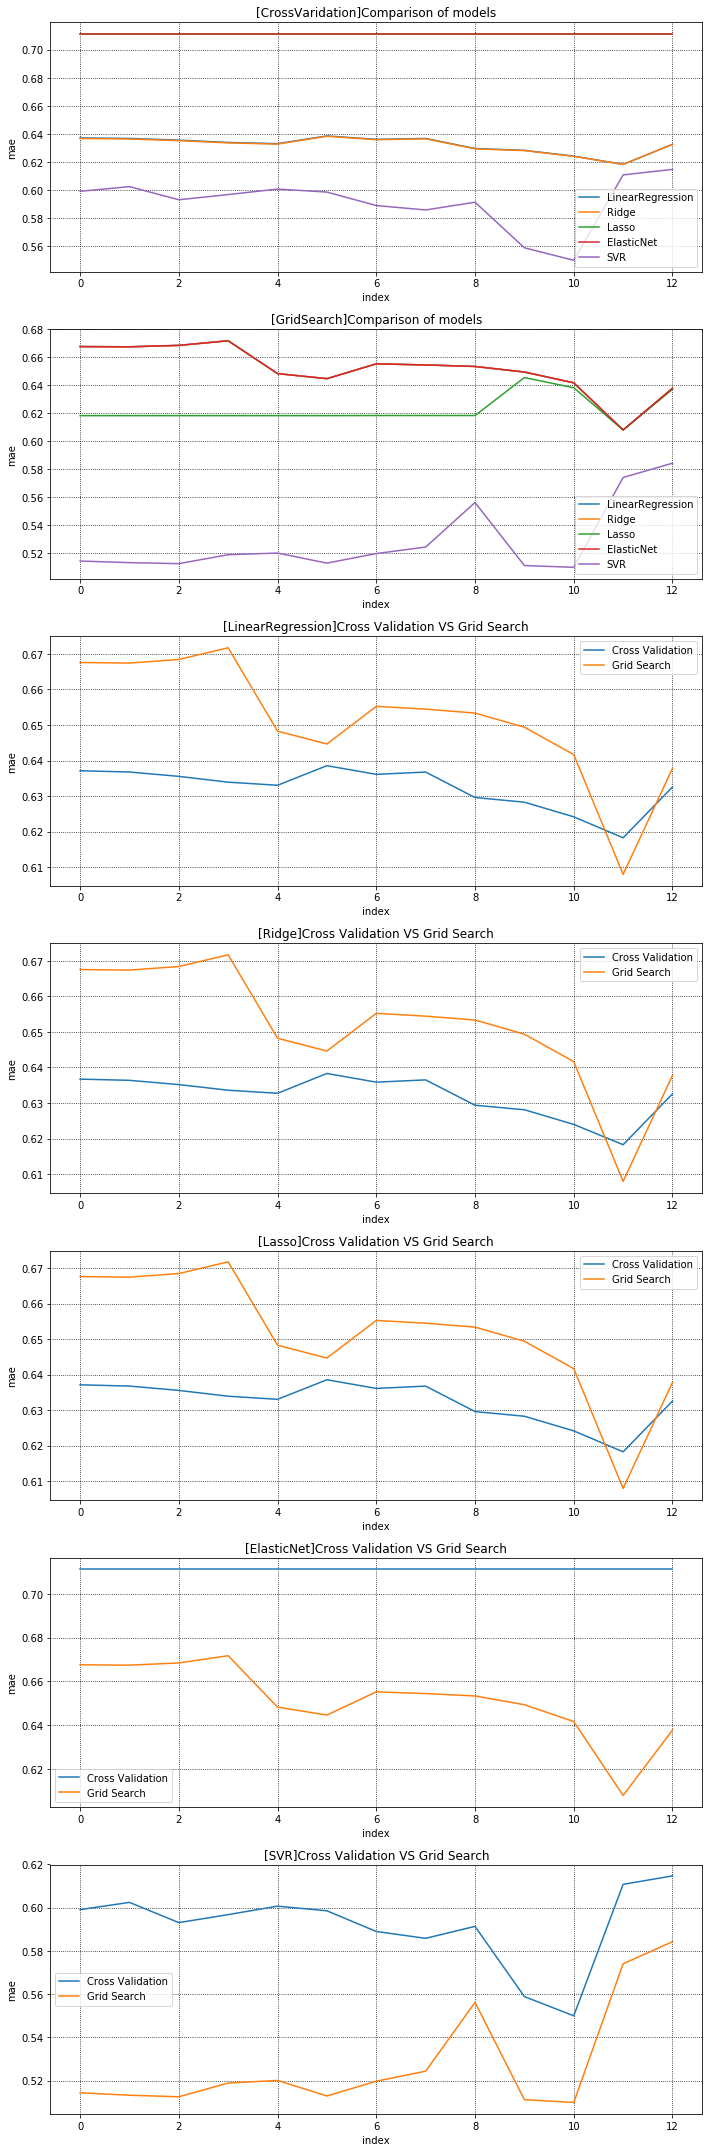

In [27]:
# グラフ表示
graph_num = 7
fig, ax = plt.subplots(graph_num, 1, figsize=(10, 30))

# モデル毎の比較（クロスバリデーション法）
ax[0].set_title('[CrossVaridation]Comparison of models')
ax[0].plot(lenearregression_cv_mae.keys(), lenearregression_cv_mae.values(), label='LinearRegression')
ax[0].plot(ridge_cv_mae.keys(), ridge_cv_mae.values(), label='Ridge')
ax[0].plot(lasso_cv_mae.keys(), lasso_cv_mae.values(), label='Lasso')
ax[0].plot(elasticnet_cv_mae.keys(), elasticnet_cv_mae.values(), label='ElasticNet')
ax[0].plot(svr_cv_mae.keys(), svr_cv_mae.values(), label='SVR')

# モデル毎の比較（グリッドサーチ法）
ax[1].set_title('[GridSearch]Comparison of models')
ax[1].plot(lenearregression_gs_mae.keys(), lenearregression_gs_mae.values(), label='LinearRegression')
ax[1].plot(ridge_gs_mae.keys(), ridge_gs_mae.values(), label='Ridge')
ax[1].plot(lasso_gs_mae.keys(), lasso_gs_mae.values(), label='Lasso')
ax[1].plot(elasticnet_gs_mae.keys(), elasticnet_gs_mae.values(), label='ElasticNet')
ax[1].plot(svr_gs_mae.keys(), svr_gs_mae.values(), label='SVR')

# クロスバリデーション法とグリッドサーチ法の比較(LinearRegression)
ax[2].set_title('[LinearRegression]Cross Validation VS Grid Search')
ax[2].plot(lenearregression_cv_mae.keys(), lenearregression_cv_mae.values(), label='Cross Validation')
ax[2].plot(lenearregression_gs_mae.keys(), lenearregression_gs_mae.values(), label='Grid Search')

# クロスバリデーション法とグリッドサーチ法の比較(Ridge)
ax[3].set_title('[Ridge]Cross Validation VS Grid Search')
ax[3].plot(ridge_cv_mae.keys(), ridge_cv_mae.values(), label='Cross Validation')
ax[3].plot(ridge_gs_mae.keys(), ridge_gs_mae.values(), label='Grid Search')

# クロスバリデーション法とグリッドサーチ法の比較(Lasso)
ax[4].set_title('[Lasso]Cross Validation VS Grid Search')
ax[4].plot(lenearregression_cv_mae.keys(), lenearregression_cv_mae.values(), label='Cross Validation')
ax[4].plot(lenearregression_gs_mae.keys(), lenearregression_gs_mae.values(), label='Grid Search')

# クロスバリデーション法とグリッドサーチ法の比較(ElasticNet)
ax[5].set_title('[ElasticNet]Cross Validation VS Grid Search')
ax[5].plot(elasticnet_cv_mae.keys(), elasticnet_cv_mae.values(), label='Cross Validation')
ax[5].plot(elasticnet_gs_mae.keys(), elasticnet_gs_mae.values(), label='Grid Search')

# クロスバリデーション法とグリッドサーチ法の比較(SVR)
ax[6].set_title('[SVR]Cross Validation VS Grid Search')
ax[6].plot(svr_cv_mae.keys(), svr_cv_mae.values(), label='Cross Validation')
ax[6].plot(svr_gs_mae.keys(), svr_gs_mae.values(), label='Grid Search')

for i in range(graph_num):
    ax[i].set_xlabel('index')
    ax[i].set_ylabel('mae')
    ax[i].grid(which='major',color='black',linestyle=':')
    ax[i].grid(which='minor',color='black',linestyle=':')
    ax[i].legend()

fig.tight_layout()
fig.show()

#### 定量評価

In [28]:
# 全体の最適解
total_min_cv_mae = min(min_cv_mae.values())
total_cv_index = [k for k, v in min_cv_mae.items() if v == total_min_cv_mae]
total_min_cv_model = min_cv_model[total_cv_index[0]]

print('\n-----------------------------------')
print('<最適解>')
print('<クロスバリデーション法>')
print('index = {}'.format(total_cv_index[0]))
print('説明変数 = {}'.format(final_exp_data[total_cv_index[0]].index))
print("モデル = {}".format(total_min_cv_model))
print("MAE = {}".format(round(total_min_cv_mae, 3)))

total_min_gs_mae = min(min_gs_mae.values())
total_gs_index = [k for k, v in min_gs_mae.items() if v == total_min_gs_mae]
total_min_gs_model = min_gs_model[total_gs_index[0]]

print('\n<グリッドサーチ法>')
print('index = {}'.format(total_gs_index[0]))
print('説明変数 = {}'.format(final_exp_data[total_gs_index[0]].index))
print("モデル = {}".format(total_min_gs_model))
print("MAE = {}".format(round(total_min_gs_mae, 3)))
print("Grid Search best param = {}".format(final_gs_best_params[total_gs_index[0]][total_min_gs_model[0]]))
print("Grid Search best score = {}".format(final_gs_best_score[total_gs_index[0]][total_min_gs_model[0]]))  


-----------------------------------
<最適解>
<クロスバリデーション法>
index = 10
説明変数 = Index(['speed', 'rain', 'temp_outside'], dtype='object')
モデル = ['SVR']
MAE = 0.55

<グリッドサーチ法>
index = 10
説明変数 = Index(['speed', 'rain', 'temp_outside'], dtype='object')
モデル = ['SVR']
MAE = 0.51
Grid Search best param = {'C': 1, 'kernel': 'rbf'}
Grid Search best score = 0.2858066687391376


## まとめ
### 検証結果
TODO

### 前回から取り組んだ内容・工夫、精度がどのように変化したか
- 重みと二乗誤差の確認は削除（使わないから）
- 相関係数の値でfor文回してたが、無駄が多いので、説明変数の数で回すように修正
- TODO